# Distribución de energías en Ln III

Paquete con cálculo de energías de Lantánidos. Las distribuciones de energía fueron extraídas del trabajos de Carnall et al (1978). Los parámetros de "Calculation of Judd-Ofelt parameters for Er3þ in β-NaYF4:Yb3þ,Er3þ from emission intensity ratios and diffuse reflectance spectra", que a su vez fueron calculados usando los trabajos de Carnall y Weber.
Por ahora está implementado el ion Er3+, pero se pueden agregar el resto de los Ln3+ de la misma forma.

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math, Image
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore')

from pyucnp import data
from pyucnp.ions import Erbium
from pyucnp.math import wavenumber_to_nm
import networkx as nx
 
er = Erbium()

## Diagrama de Dieke
La idea es simular y usar la información de los diagramas de Dieke para los lantánidos, es decir

<img src="dieke_simplified.png" width="600">

Los datos completos de las tablas están en la clase, juto con todos los estados degenerados.

In [2]:
# Los primeros 10 valores
er.df_carnall.head(10)

,observed,calculated,o-c,state,j,mj
0,0,-9,10,4I,15/2,13/2
1,51,50,4,4I,15/2,-11/2
2,121,121,0,4I,15/2,3/2
3,200,188,12,4I,15/2,5/2
4,219,198,22,4I,15/2,1/2
5,314,310,4,4I,15/2,-9/2
6,400,397,3,4I,15/2,-7/2
7,443,442,1,4I,15/2,15/2
8,6604,6607,-2,4I,13/2,-11/2
9,6630,6639,-8,4I,13/2,-9/2


## Graficando las energías

Puedo primero ver cuales son los estados excitables del ion, sin importar los números J ni MJ

In [3]:
print(er.available_states())

['4I' '4F' '4S' '2H2' '4G' '2K' '2P' '2D1' '4D' '2I' '2L' '2H1' '2D2']


Y una vez hecho esto calcular las energías medias de cada nivel (estado+J)

In [5]:
# Los primeros 10 valores
er.energy_levels(units='wavenumber').head(60)

calculated
state j                 
2D1   5/2   35062.333333
2D2   5/2   49282.000000
2H1   11/2  51413.833333
      9/2   48433.800000
2H2   11/2  19330.333333
      9/2   36643.000000
2I    11/2  41353.666667
      13/2  43800.857143
2K    1/2   33317.000000
      13/2  33186.857143
      15/2  27925.250000
2L    15/2  48057.875000
      17/2  41928.333333
2P    3/2   31738.000000
4D    3/2   42697.000000
      5/2   38827.000000
      7/1   47313.000000
      7/2   39464.750000
4F    3/2   22715.000000
      5/2   22377.333333
      7/2   20719.250000
      9/2   19222.000000
4G    11/2  26617.166667
      5/2   33529.666667
      7/2   30229.750000
      9/2   26431.000000
4I    11/2  10343.166667
      13/2   6707.000000
      15/2    212.125000
      9/2   12594.200000
4S    3/2   18573.500000

O de algún estado particular, por ejemplo la transición 4G 11/2 al fundamental en nanómetros se puede obtener según

In [6]:
mean_e, std_e = er.mean_energy(('4G', '11/2'))
f"Transition 4H 11/2 -> 4I 15/2 is {mean_e:.1f} cm^-1 or {wavenumber_to_nm(mean_e):.1f} nm"
# wavenumber_to_nm(er.mean_energy('4G', '11/2'))
display(Math(fr"4G_{{11/2}} \rightarrow 4I_{{15/2}}: {mean_e:.1f}\; cm^{{-1}} = {wavenumber_to_nm(mean_e):.1f}\;nm"))
display(Math(fr"4H_{{11/2}} \rightarrow 4I_{{15/2}}: {mean_e:.1f}\; cm^{{-1}} = {wavenumber_to_nm(mean_e):.1f}\;nm"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

También se puede poner el estado final para calcular energías relativas entre bandas.

In [9]:
mean_e, std_e = er.mean_energy(('4S', '3/2'), ('4F', '9/2'))
display(Math(fr"4F_{{3/2}} \rightarrow 2H2_{{11/2}}: {mean_e:.1f}\; cm^{{-1}}"))

<IPython.core.display.Math object>

## Mostrando las distintas transiciones

Con estos datos se puede replicar el diagrama de Dieke a partir de los datos de Carnall et al. Cada estado J tiene multiplicidad de MJ, pero si se supone que termodinámicamente se promedian y se usan todos los valores para calcular el ancho de cada banda se puede replicar el  diagrama de Dieke.

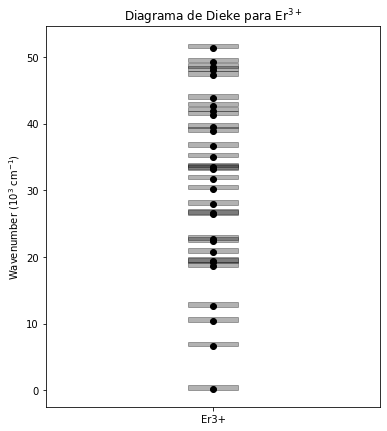

In [7]:
levels_df = er.energy_levels(units='wavenumber')
energies = levels_df.values/1e3
xpos = np.ones_like(energies)

# Create figure and axes
fig, ax = plt.subplots(1, 1, figsize=(6, 7))
for e in energies:
    rect = plt.Rectangle((.85, e-.1), .3, 0.7, color='k', alpha=0.3)
    ax.add_patch(rect)
ax.set_xlim([0, 2])
ax.set_title('Diagrama de Dieke para Er$^{3+}$')
ax.set_ylabel('Wavenumber (10$^3$ cm$^{-1}$)')
ax.plot(xpos, energies, 'ok')
plt.xticks([1], ('Er3+',))
plt.show()

Ahora puedo agregar los datos de los cocientes de ramificacion y coeficientes de einstei para evaluar las transiciones más probables y usarlas en los ajustes
<img src="branching_ratios.png" width="400">
Estos datos se pueden obtener usando

In [8]:
tran_df = er.transitions
tran_df

,from,to,ajj,kr,beta
0,"(2H2,9/2)","(4I,15/2)",875,1896,46.2
1,"(2H2,9/2)","(4I,13/2)",760,-,40.1
2,"(2H2,9/2)","(4I,11/2)",183,-,9.7
3,"(2H2,9/2)","(4I,9/2)",16,-,0.8
4,"(2H2,9/2)","(4F,9/2)",49,-,2.6
5,"(2H2,9/2)","(4S,3/2)",0,-,0.0
6,"(2H2,9/2)","(2H2,11/2)",7,-,0.4
7,"(2H2,9/2)","(4F,7/2)",4,-,0.2
8,"(2H2,9/2)","(4F,5/2)",0,-,0.0
9,"(2H2,9/2)","(4F,3/2)",0,-,0.0


Los coeficientes $A_{JJ}$ son los números de Einstein y se cumple que $A_{JJ} = A_{ED}+A_{MD}$, valores de los cuales se pueden obtener algunos coeficientes como $\tau_R=1/\sum{A_{JJ}}$ y los branching ratios (beta). Ambos en la tabla ya están calculados.

In [9]:
to_levels = levels_df.index.map('({0[0]},{0[1]})'.format)
tran_df[tran_df['to'] == to_levels]

,from,to,ajj,kr,beta
28,"(4I,11/2)","(4I,15/2)",108,129,83.8


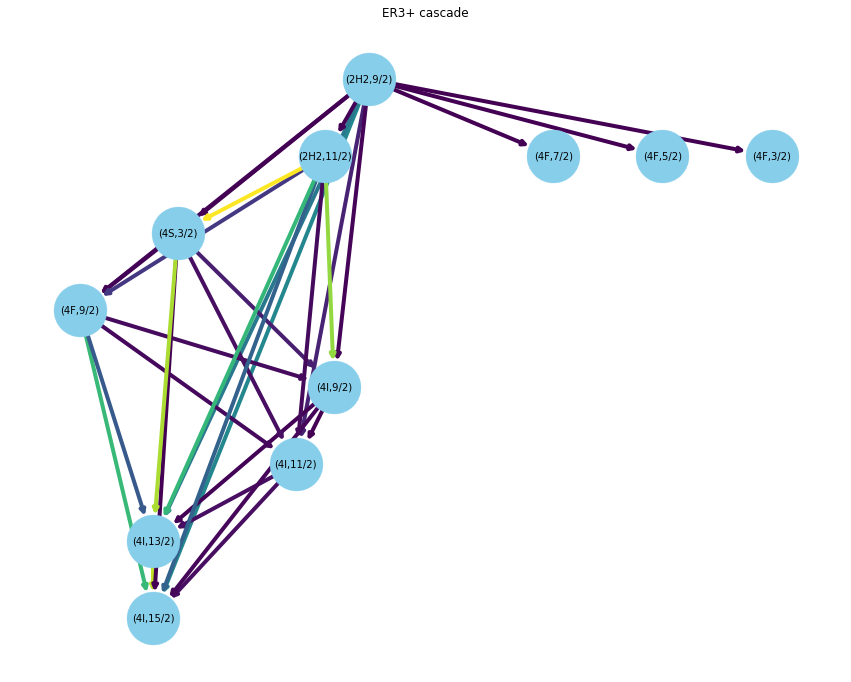

In [11]:
# Buyilñd your cmap
import matplotlib as mpl
from networkx.drawing.nx_agraph import write_dot, graphviz_layout


my_cmap = plt.cm.Reds
# my_cmap.

# Build your graph
plt.figure(1,figsize=(15,12)) 
G=nx.from_pandas_edgelist(tran_df, 'from', 'to', create_using=nx.DiGraph() )
# Custom the nodes:
#write_dot(G,'test.dot')
plt.figure(1,figsize=(8,8))
my_cmap = plt.get_cmap('viridis')
# same layout using matplotlib with no labels
plt.title('ER3+ cascade')
pos = graphviz_layout(G, prog='dot')
nx.draw(G, with_labels=True, node_color='skyblue',
        node_size=2800, edge_color=tran_df['beta'], width=4.0, 
        edge_cmap=my_cmap, linewidths=.4, font_size=10, pos=pos)